In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

## Data Loading

In [3]:
def findFiles(path):
    return glob.glob(path)

In [4]:
import unicodedata
import string

In [5]:
all_letters = string.ascii_letters + ",.;'"
n_letters = len(all_letters)

In [6]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;'"

In [14]:
# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

In [16]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [17]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

In [24]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [25]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [31]:
len(category_lines['Korean'])

94

## data to Tensor

In [32]:
import torch

In [33]:
# find index of letter
def letterToIndex(letter):
    return all_letters.find(letter)

# 이름(word, line)을 <line_length x 1 x n_letters>로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [38]:
lineToTensor('Jones').shape # 5 -> len('Jones'), 1(batch), 56(len(all_letters))

torch.Size([5, 1, 56])

## Network

In [39]:
from torch import nn

### RNN 

$$ h_t = W_{i2h}(h_{t-1}\mathbin\Vert x_{t-1}) $$
$$ y_t = softmax(W_{i2o}(h_{t-1}\mathbin\Vert x_{t-1})) $$
$$ _{(\mathbin\Vert \space denotes \space concatenation)} $$

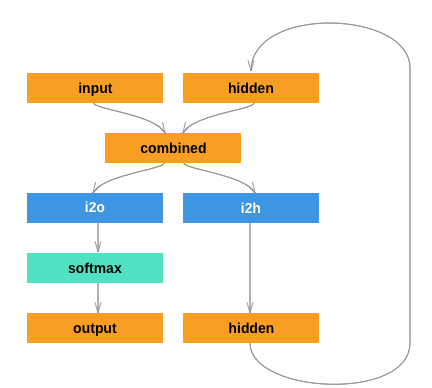

In [114]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        # nn.Module내의 다른 매개변수는 상속하게 super에서 처리되는데 hidden_size는 없는듯
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) 
        # dim = 1 의 의미 : batch 내에서(한데이터셋 묶음 안에서) softmax를 구한다
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        # dim = 1 의 의미 : input과 hidden을 옆으로 붙인다
        # input의 shape는 (bacth_size x input_size)
        # hidden의 shape는 (bacth_size x hidden_size)
        # combined의 shape는 (bacth_size x (input_size + hidden_size))가 된다
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)        

### c.f. 차원에 대해 알아보자

In [115]:
# dim 0 : 데이터 셋 같은 위치내에 있는 것끼리 softmax 구함
softmax = nn.Softmax(dim=0)
softmax(torch.tensor([[1,2,3,4], [2,3,4,5]], dtype=torch.float32))
# dim 1 : 데이터 셋 내에서 softmax 구함
softmax = nn.Softmax(dim=1)
softmax(torch.tensor([[1,2,3,4], [2,3,4,5]], dtype=torch.float32))

tensor([[0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439]])

In [116]:
def print_concat(a, b, dim):
    concatened = torch.cat((a,b), dim=dim)
    print('dim={}: \n{} \nshape:{}'.format(dim, concatened, concatened.shape))

In [117]:
a = torch.Tensor([[1,2,3,4], [5,6,7,8]])
b = torch.Tensor([[2,3,4,5], [6,7,8,9]])
print_concat(a, b, 0)
print_concat(a, b, 1)
print_concat(a, b, -1)

dim=0: 
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.],
        [2., 3., 4., 5.],
        [6., 7., 8., 9.]]) 
shape:torch.Size([4, 4])
dim=1: 
tensor([[1., 2., 3., 4., 2., 3., 4., 5.],
        [5., 6., 7., 8., 6., 7., 8., 9.]]) 
shape:torch.Size([2, 8])
dim=-1: 
tensor([[1., 2., 3., 4., 2., 3., 4., 5.],
        [5., 6., 7., 8., 6., 7., 8., 9.]]) 
shape:torch.Size([2, 8])


In [118]:
input = torch.Tensor([[1,2,3,4]])
hidden = torch.Tensor([[2,3,4,5]])
print_concat(input, hidden, 1)

dim=1: 
tensor([[1., 2., 3., 4., 2., 3., 4., 5.]]) 
shape:torch.Size([1, 8])


## model instance test

In [119]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden) # initial hidden statate as zero vector
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.8873, -2.9025, -2.9093, -2.8569, -2.8497, -2.9407, -2.8069, -2.7789,
         -2.9414, -2.9758, -2.8958, -2.9327, -2.9282, -2.9047, -2.9204, -2.9913,
         -2.8183, -2.8162]], grad_fn=<LogSoftmaxBackward>)

## prepare for train

In [120]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 7)


In [121]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Sarna
category = Korean / line = Wang
category = Russian / line = Yakshibaev
category = Russian / line = Zhupikov
category = Polish / line = Kozlow
category = Japanese / line = Horri
category = Irish / line = Damhan
category = Spanish / line = Valencia
category = Chinese / line = Long
category = Irish / line = Duncan


## train network 

In [125]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [130]:
def train(category_tensor, line_tensor):
    # 한 배치에 대한 train 코드
    hidden = rnn.initHidden() # hidden layer 초기화

    rnn.zero_grad() # gradient 초기화

    for i in range(line_tensor.size()[0]): # 글자마다 
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward() # 역전파 진행

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss

In [131]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.8611 Entler / French ✗ (Czech)
10000 10% (0m 11s) 1.4935 Chweh / Vietnamese ✗ (Korean)
15000 15% (0m 16s) 1.2980 Vo / Vietnamese ✓
20000 20% (0m 22s) 0.3178 Zielinski / Polish ✓
25000 25% (0m 28s) 2.8826 Rompu / English ✗ (Dutch)
30000 30% (0m 36s) 0.3937 Nahas / Arabic ✓
35000 35% (0m 42s) 1.0360 Rademaker / German ✓
40000 40% (0m 47s) 1.6626 Henriques / Dutch ✗ (Portuguese)
45000 45% (0m 53s) 0.1366 O'Gorman / Irish ✓
50000 50% (0m 59s) 2.0453 Fabian / Irish ✗ (French)
55000 55% (1m 4s) 1.9173 Dan / Vietnamese ✗ (Chinese)
60000 60% (1m 10s) 2.0990 Watson / Scottish ✗ (English)
65000 65% (1m 15s) 0.3804 Araujo / Portuguese ✓
70000 70% (1m 21s) 0.8534 Lobo / Portuguese ✓
75000 75% (1m 26s) 0.6600 Gwang / Korean ✓
80000 80% (1m 32s) 9.2649 Sen / Korean ✗ (Japanese)
85000 85% (1m 37s) 1.3538 Pak / Vietnamese ✗ (Korean)
90000 90% (1m 42s) 1.4629 Hachirobei / Dutch ✗ (Japanese)
95000 95% (1m 48s) 2.8660 Devine / French ✗ (English)
100000 100% (1m 53s) 1.4672 Vivas / Greek

## learning curve

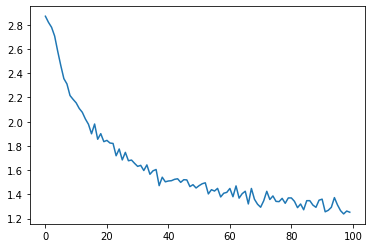

In [132]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## evaluation ( metrics )  

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


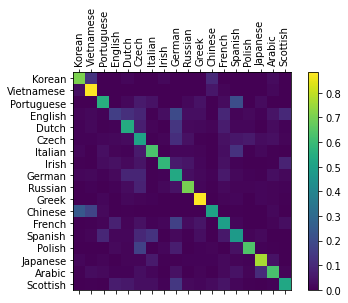

In [133]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()